# Lower limits of detection of Malaria Parasites in dried blood spots when using Mid-Infrared Spectroscopy and Machine Learning approaches in presence and absence of anemia 


##  Importing all useful Libraries for our analyis ##

In [2]:
#Import impontant modules

import numpy as np 
import pandas as pd  
import scipy.stats as stats

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold

#Import ML classifiers
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

import os
import ast
import itertools
import collections
from time import time
from tqdm import tqdm 
import collections
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

## Prepare confusion matrix plot

In [3]:

def plot_confusion_matrix(cm, classes,
                          normalise=True,
                          text=True,
                          title='Confusion matrix',color='r',
                          xrotation=0,
                          yrotation=0,
                          saturation=2,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalise=True'.
    """

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "{0} (normalised)".format(title)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0.009,0.91], ["Positive", 'Negative'],fontsize=18)
    plt.yticks([0.008,0.81], ["Positive", 'Negative'],fontsize=18,rotation=90)

    if text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]),
                                      range(cm.shape[1])):
            plt.text(j, i, "{0:.2f}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color= 'black',fontsize=20, Weight="bold")
    plt.xlabel('Predicted label', color='black',fontsize=20, Weight="bold")

## Validation for Field dataset

In [4]:
dfmwanga=pd.read_csv("DBS_field_2019_Final.dat", delimiter= '\t') # Loading all data
dfmwanga

,Cat1,ID,Cat3,StoTime,3855,3853,3851,3849,3847,3845,...,545,543,541,539,537,535,533,531,529,527
0,DS,1,NG,1280,0.0141,0.0141,0.0139,0.0135,0.0131,0.0132,...,0.1291,0.1254,0.1223,0.1203,0.1189,0.1173,0.1158,0.1158,0.1187,0.1237
1,DS,2,NG,1280,0.0153,0.0153,0.0152,0.0151,0.0149,0.0149,...,0.1443,0.1387,0.1330,0.1285,0.1257,0.1243,0.1244,0.1256,0.1282,0.1329
2,DS,3,NG,1280,0.0153,0.0152,0.0151,0.0150,0.0150,0.0149,...,0.1558,0.1520,0.1475,0.1429,0.1392,0.1379,0.1407,0.1479,0.1582,0.1695
3,DS,4,NG,1280,0.0151,0.0151,0.0152,0.0152,0.0152,0.0151,...,0.1268,0.1271,0.1283,0.1300,0.1316,0.1320,0.1304,0.1279,0.1264,0.1275
4,DS,5,NG,1280,0.0158,0.0157,0.0157,0.0158,0.0157,0.0156,...,0.1336,0.1325,0.1321,0.1321,0.1321,0.1323,0.1335,0.1362,0.1398,0.1431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,DS,228,PS,1280,0.0133,0.0132,0.0132,0.0133,0.0134,0.0135,...,0.1264,0.1244,0.1218,0.1190,0.1164,0.1139,0.1119,0.1115,0.1138,0.1189
248,DS,230,PS,1280,0.0130,0.0129,0.0130,0.0131,0.0133,0.0134,...,0.1199,0.1159,0.1129,0.1121,0.1130,0.1144,0.1152,0.1144,0.1120,0.1098
249,DS,231,PS,1280,0.0127,0.0128,0.0128,0.0129,0.0129,0.0128,...,0.1141,0.1123,0.1111,0.1112,0.1124,0.1133,0.1129,0.1102,0.1058,0.1015
250,DS,232,PS,1280,0.0134,0.0135,0.0135,0.0137,0.0138,0.0139,...,0.1301,0.1286,0.1270,0.1258,0.1251,0.1246,0.1238,0.1223,0.1207,0.1204


In [8]:
df2 = dfmwanga.groupby(['Cat3']).size().reset_index(name="Count")
print (df2)

  Cat3  Count
0   NG    145
1   PS    107


# Prepare the field data to look similar to our previous trained model

In [9]:
dfmwanga["Cat3"]=dfmwanga["Cat3"].replace({'PS': 'Positive', 'NG': 'Negative'})
dfmwanga

,Cat1,ID,Cat3,StoTime,3855,3853,3851,3849,3847,3845,...,545,543,541,539,537,535,533,531,529,527
0,DS,1,Negative,1280,0.0141,0.0141,0.0139,0.0135,0.0131,0.0132,...,0.1291,0.1254,0.1223,0.1203,0.1189,0.1173,0.1158,0.1158,0.1187,0.1237
1,DS,2,Negative,1280,0.0153,0.0153,0.0152,0.0151,0.0149,0.0149,...,0.1443,0.1387,0.1330,0.1285,0.1257,0.1243,0.1244,0.1256,0.1282,0.1329
2,DS,3,Negative,1280,0.0153,0.0152,0.0151,0.0150,0.0150,0.0149,...,0.1558,0.1520,0.1475,0.1429,0.1392,0.1379,0.1407,0.1479,0.1582,0.1695
3,DS,4,Negative,1280,0.0151,0.0151,0.0152,0.0152,0.0152,0.0151,...,0.1268,0.1271,0.1283,0.1300,0.1316,0.1320,0.1304,0.1279,0.1264,0.1275
4,DS,5,Negative,1280,0.0158,0.0157,0.0157,0.0158,0.0157,0.0156,...,0.1336,0.1325,0.1321,0.1321,0.1321,0.1323,0.1335,0.1362,0.1398,0.1431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,DS,228,Positive,1280,0.0133,0.0132,0.0132,0.0133,0.0134,0.0135,...,0.1264,0.1244,0.1218,0.1190,0.1164,0.1139,0.1119,0.1115,0.1138,0.1189
248,DS,230,Positive,1280,0.0130,0.0129,0.0130,0.0131,0.0133,0.0134,...,0.1199,0.1159,0.1129,0.1121,0.1130,0.1144,0.1152,0.1144,0.1120,0.1098
249,DS,231,Positive,1280,0.0127,0.0128,0.0128,0.0129,0.0129,0.0128,...,0.1141,0.1123,0.1111,0.1112,0.1124,0.1133,0.1129,0.1102,0.1058,0.1015
250,DS,232,Positive,1280,0.0134,0.0135,0.0135,0.0137,0.0138,0.0139,...,0.1301,0.1286,0.1270,0.1258,0.1251,0.1246,0.1238,0.1223,0.1207,0.1204


In [19]:
# # Select targets and features
X = dfmwanga.loc[:,"3855":"527"]

Y= dfmwanga["Cat3"]
X

,3855,3853,3851,3849,3847,3845,3843,3841,3839,3837,...,545,543,541,539,537,535,533,531,529,527
0,0.0141,0.0141,0.0139,0.0135,0.0131,0.0132,0.0135,0.0137,0.0137,0.0137,...,0.1291,0.1254,0.1223,0.1203,0.1189,0.1173,0.1158,0.1158,0.1187,0.1237
1,0.0153,0.0153,0.0152,0.0151,0.0149,0.0149,0.0148,0.0148,0.0148,0.0148,...,0.1443,0.1387,0.1330,0.1285,0.1257,0.1243,0.1244,0.1256,0.1282,0.1329
2,0.0153,0.0152,0.0151,0.0150,0.0150,0.0149,0.0149,0.0148,0.0148,0.0149,...,0.1558,0.1520,0.1475,0.1429,0.1392,0.1379,0.1407,0.1479,0.1582,0.1695
3,0.0151,0.0151,0.0152,0.0152,0.0152,0.0151,0.0150,0.0148,0.0148,0.0148,...,0.1268,0.1271,0.1283,0.1300,0.1316,0.1320,0.1304,0.1279,0.1264,0.1275
4,0.0158,0.0157,0.0157,0.0158,0.0157,0.0156,0.0155,0.0153,0.0152,0.0152,...,0.1336,0.1325,0.1321,0.1321,0.1321,0.1323,0.1335,0.1362,0.1398,0.1431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.0133,0.0132,0.0132,0.0133,0.0134,0.0135,0.0135,0.0135,0.0134,0.0132,...,0.1264,0.1244,0.1218,0.1190,0.1164,0.1139,0.1119,0.1115,0.1138,0.1189
248,0.0130,0.0129,0.0130,0.0131,0.0133,0.0134,0.0134,0.0133,0.0132,0.0132,...,0.1199,0.1159,0.1129,0.1121,0.1130,0.1144,0.1152,0.1144,0.1120,0.1098
249,0.0127,0.0128,0.0128,0.0129,0.0129,0.0128,0.0128,0.0127,0.0126,0.0126,...,0.1141,0.1123,0.1111,0.1112,0.1124,0.1133,0.1129,0.1102,0.1058,0.1015
250,0.0134,0.0135,0.0135,0.0137,0.0138,0.0139,0.0138,0.0136,0.0133,0.0131,...,0.1301,0.1286,0.1270,0.1258,0.1251,0.1246,0.1238,0.1223,0.1207,0.1204


In [20]:
df2 = dfmwanga.groupby(['Cat3']).size().reset_index(name="Count") 
print (df2)

       Cat3  Count
0  Negative    145
1  Positive    107


In [21]:
RSC= RandomUnderSampler(random_state = None) # balancing classes by rondom undersampling technique
X_us, y_us = RSC.fit_sample(X, Y)
y_us_count = collections.Counter(y_us)
print(y_us_count)

Counter({'Negative': 107, 'Positive': 107})


In [22]:
X_us = MinMaxScaler().fit_transform(X_us)
X_us

array([[0.69318182, 0.67816092, 0.68181818, ..., 0.70786517, 0.67937853,
        0.52267003],
       [0.70454545, 0.68965517, 0.65909091, ..., 0.57303371, 0.57627119,
        0.49118388],
       [0.53409091, 0.52873563, 0.54545455, ..., 0.45646067, 0.42655367,
        0.302267  ],
       ...,
       [0.42045455, 0.42528736, 0.43181818, ..., 0.31460674, 0.21468927,
        0.06926952],
       [0.5       , 0.50574713, 0.51136364, ..., 0.48455056, 0.42514124,
        0.30730479],
       [0.625     , 0.62068966, 0.625     , ..., 0.56741573, 0.50141243,
        0.35894207]])

# Load our saved model trained on laboratory data and predict

In [23]:
import joblib
import pickle
# # Unpickle the model from the file
with open('Malaria_classifier.pk2', 'rb') as file:
    loaded_Malaria_Classifer = pickle.load(file)
    
loaded_Malaria_Classifer

C:\Users\Issa Mshani\anaconda3\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.23.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LogisticRegressionCV(max_iter=3500, random_state=4, solver='newton-cg')

## Let us do prediction

In [24]:
# predict with bestClassifier
Y_val_pred = loaded_Malaria_Classifer.predict(X_us)

In [25]:
# accuracy of our classifier to the field data
accuracy = accuracy_score(y_us, Y_val_pred) 
print("Accuracy:%.2f%%" %(accuracy * 100.0))

Accuracy:82.94%


In [27]:
report = classification_report(y_us, Y_val_pred)
print(report)

              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85       145
    Positive       0.81      0.79      0.80       107

    accuracy                           0.83       252
   macro avg       0.83      0.82      0.82       252
weighted avg       0.83      0.83      0.83       252



Normalized confusion matrix


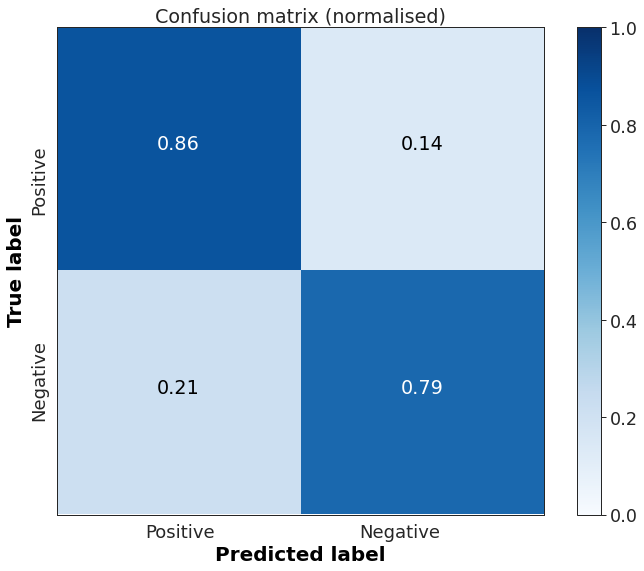

In [28]:
# plotting confusion matrix 
sns.set(context="paper", 
        style="white", 
        font_scale = 2.0,
        rc={"font.family": "Dejavu Sans"}) 
plt.rcParams["figure.figsize"] = [10,8] 

cm = confusion_matrix(y_us, Y_val_pred) 
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
plt.imshow(cm_percentage, cmap='Blues', interpolation='nearest', vmin=0, vmax=100)
class_names = np.unique(np.sort(y_us)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      cmap= 'Blues',
                      classes=class_names) 


[0.82539683 0.8452381  0.79365079 0.84920635 0.80952381 0.83730159
 0.84126984 0.79761905 0.82539683 0.8452381  0.82142857 0.83730159
 0.85714286 0.8531746  0.81746032 0.83333333 0.87698413 0.76984127
 0.82142857 0.83333333 0.8452381  0.80555556 0.84126984 0.83333333
 0.85714286 0.82142857 0.84920635 0.82936508 0.82539683 0.86507937
 0.82936508 0.86904762 0.81746032 0.83730159 0.83730159 0.8531746
 0.82539683 0.83333333 0.80952381 0.77777778 0.81746032 0.81746032
 0.79761905 0.81349206 0.84126984 0.84126984 0.79761905 0.83333333
 0.84126984 0.80952381 0.81349206 0.86111111 0.8015873  0.85714286
 0.79761905 0.82142857 0.85714286 0.8452381  0.84920635 0.82936508
 0.83333333 0.8531746  0.8015873  0.84920635 0.86111111 0.81349206
 0.83333333 0.79761905 0.8015873  0.82936508 0.80952381 0.80952381
 0.84126984 0.84920635 0.84920635 0.83730159 0.8015873  0.80952381
 0.87301587 0.86111111 0.86111111 0.83333333 0.77777778 0.80952381
 0.79761905 0.86111111 0.87698413 0.86507937 0.8452381  0.85714

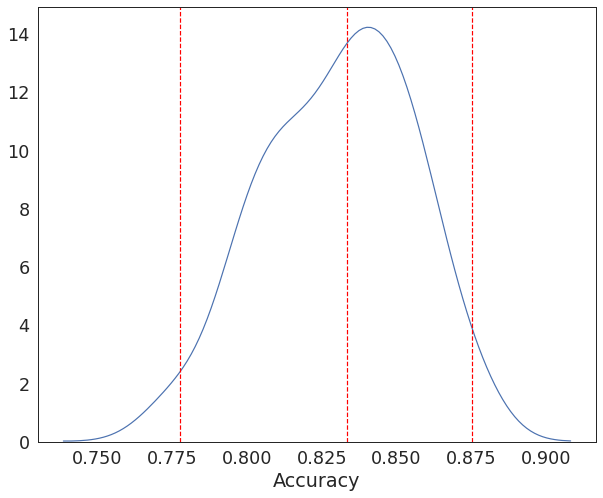

In [29]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_us, y_us,random_state=None)

    # Make predictions using the already trained model
    y_pred =  loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# median
median = np.percentile(validation_scores, 50)

# 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################
sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()